In [32]:
import os
import sys
# Construct the path to the directory you want to import from
# '..' goes up one directory level. Adjust as needed.
module_path = os.path.abspath(os.path.join('..'))

# Add the directory to sys.path
if module_path not in sys.path:
    sys.path.append(module_path)

from gridworld_env_layout import GridWorldMDPFromLayoutEnv
from gridworld_env import NoisyLinearRewardFeaturizedGridWorldEnv
import numpy as np
from agent.q_learning_agent import ValueIteration, PolicyEvaluation
from scipy.optimize import linprog

from utils.machine_teaching_utils import (build_Pi_from_q,
compute_successor_features_iterative_from_q,
 derive_constraints_from_q_ties, 
 remove_redundant_constraints,
 generate_candidates_from_q,
 plot_halfspace_intersection_2d)

from reward_learning.multi_env_birl import MultiEnvBIRL
from utils.common_helper import  bucket_and_dedup

from utils.env_helper import print_policy_from_q

### Making different mdps

In [33]:
W_TRUE = np.array([-10, -2])/np.linalg.norm([-10, -2])

layout_1 = [
    ["blue",  "red", "blue"],
    ["blue", "blue",  "blue"],
]

layout_2 = [
    ["blue",  "red", "blue"],
    ["red", "blue",  "blue"],
]

layout_3 = [
    ["blue",  "red", "blue"],
    ["blue", "red",  "blue"],
]

layout_4 = [
    ["blue",  "blue", "red"],
    ["blue", "blue",  "blue"],
]

layout_5 = [
    ["blue",  "red", "blue"],
    ["blue", "red",  "blue"],
]


color_to_feature_map = {
    "red":  [1.0, 0.0],
    "blue": [0.0, 1.0],
}

rows, cols = 2, 3

env_5 = GridWorldMDPFromLayoutEnv(
    gamma=0.99,
    layout=layout_1,
    color_to_feature_map=color_to_feature_map,
    noise_prob=0,
    terminal_states=[0],
    custom_feature_weights=W_TRUE,
    render_mode=None,
)

env_2 = GridWorldMDPFromLayoutEnv(
    gamma=0.99,
    layout=layout_2,
    color_to_feature_map=color_to_feature_map,
    noise_prob=0,
    terminal_states=[1],
    custom_feature_weights=W_TRUE,
    render_mode=None,
)

env_3 = GridWorldMDPFromLayoutEnv(
    gamma=0.99,
    layout=layout_3,
    color_to_feature_map=color_to_feature_map,
    noise_prob=0,
    terminal_states=[2],
    custom_feature_weights=W_TRUE,
    render_mode=None,
)

env_4 = GridWorldMDPFromLayoutEnv(
    gamma=0.99,
    layout=layout_4,
    color_to_feature_map=color_to_feature_map,
    noise_prob=0,
    terminal_states=[3],
    custom_feature_weights=W_TRUE,
    render_mode=None,
)

env_1 = GridWorldMDPFromLayoutEnv(
    gamma=0.99,
    layout=layout_5,
    color_to_feature_map=color_to_feature_map,
    noise_prob=0,
    terminal_states=[0],
    custom_feature_weights=W_TRUE,
    render_mode=None,
)

envs = [env_1, env_2, env_3, env_4, env_5]

vis = [ValueIteration(env) for env in envs]

envs_V = [vi.run_value_iteration(epsilon=1e-10) for vi in vis]

envs_Q = [vi.get_q_values() for vi in vis]

In [34]:
for i, env in enumerate(envs):

    print_policy_from_q(envs_Q[i], rows=2, cols=3, tie_eps=1e-8, terminal_states=env.terminal_states)

T | < | <
^ | < | ^

>  | T  | < 
^> | ^  | ^<

> | > | T
^ | > | ^

v  | v< | v<
T  | <  | < 

T | < | v
^ | < | <



In [35]:
def build_Pi_from_q_family(envs, Q_list, tie_eps=1e-10):
    Pis = []
    for env, q in zip(envs, Q_list):
        Pis.append(build_Pi_from_q(env, q, tie_eps=tie_eps))
    return Pis

def compute_successor_features_family(envs, Q_list, **kw):
    out = []
    for env, q in zip(envs, Q_list):
        mu_sa, mu_s, Phi, P_pi = compute_successor_features_iterative_from_q(env, q, **kw)
        out.append((mu_sa, mu_s, Phi, P_pi))
    return out

def derive_constraints_family(SFs, Q_list, envs, tie_eps=1e-10,
                              skip_terminals=True, normalize=True, tol=1e-12,
                              precision=1e-3, lp_epsilon=1e-4):
    U_per_mdp = []
    all_H = []
    for (mu_sa, _, _, _), q, env in zip(SFs, Q_list, envs):
        cons = derive_constraints_from_q_ties(mu_sa, q, env,
                                              tie_eps=tie_eps,
                                              skip_terminals=skip_terminals,
                                              normalize=normalize, tol=tol)
        H_i = [c[0] if isinstance(c, tuple) else c for c in cons]  # keep vectors
        U_per_mdp.append(H_i)
        all_H.extend(H_i)

    # spherical dedup by cosine threshold
    pre = []
    for v in all_H:
        if not any(np.dot(v, u) / (np.linalg.norm(v)*np.linalg.norm(u)) > 1-precision for u in pre):
            pre.append(v)

    # LP redundancy removal on the family set (your existing routine)
    U_global = np.array(remove_redundant_constraints(pre, epsilon=lp_epsilon))
    return U_per_mdp, U_global

def generate_candidates_from_q_family(envs, Q_list, **kw):
    C = []
    for env, q in zip(envs, Q_list):
        C.append(generate_candidates_from_q(env, q, **kw))
    return C

def scot_greedy_family_unweighted(
    U_global,       # np.ndarray of unit normals in R^d (family universe)
    candidates,     # List[List[Traj]] per MDP: candidates[i] = list of trajectories for MDP i
    SFs,            # List[(mu_sa, mu_s, Phi, P_pi)] per MDP; we use mu_sa only
    normalize=True,
    round_decimals=12,
):
    """
    Unweighted greedy set cover over family constraints.
    Returns:
        chosen: List[(mdp_index, trajectory)] until U_global is covered or no progress possible.
    """
    m = len(candidates)
    mu_sa_list = [sf[0] for sf in SFs]  # (S_i, A_i, d)

    # stable key for a direction vector
    def key_for(v):
        n = np.linalg.norm(v)
        if not np.isfinite(n) or n == 0.0:
            return ("ZERO",)
        vv = v / n if normalize else v
        return tuple(np.round(vv, round_decimals))

    # index universe by direction key
    key_to_uix = {}
    for idx, v in enumerate(U_global):
        key_to_uix.setdefault(key_for(v), []).append(idx)

    universe = set(range(len(U_global)))
    covered  = set()
    chosen   = []

    # precompute coverage set for each candidate trajectory (against U_global)
    cov = [[set() for _ in cand_i] for cand_i in candidates]
    for i, (cand_i, mu_sa) in enumerate(zip(candidates, mu_sa_list)):
        S_i, A_i, _ = mu_sa.shape
        for j, tau in enumerate(cand_i):
            covered_by_tau = set()
            for (s, a) in tau:
                psi_star = mu_sa[s, a]
                for b in range(A_i):
                    if b == a:
                        continue
                    v = psi_star - mu_sa[s, b]
                    k = key_for(v)
                    if k in key_to_uix:
                        covered_by_tau.update(key_to_uix[k])
            cov[i][j] = covered_by_tau

    # greedy loop: pick the candidate with the largest new coverage
    while True:
        uncovered = universe - covered
        if not uncovered:
            break

        best_gain = 0
        best_item = None
        best_new  = None

        for i in range(m):
            for j in range(len(candidates[i])):
                if not cov[i][j]:
                    continue
                new_cover = uncovered & cov[i][j]
                gain = len(new_cover)
                if gain > best_gain:
                    best_gain, best_item, best_new = gain, (i, j), new_cover

        if best_item is None:  # no candidate adds new coverage
            break

        i, j = best_item
        chosen.append((i, candidates[i][j]))
        covered |= best_new

    return chosen

In [ ]:
# --- 1) Successor features per MDP (from Q) ---
SFs = compute_successor_features_family(
    envs,
    envs_Q,
    convention="entering",
    zero_terminal_features=True,
    tol=1e-10,
    max_iters=10000,
)

# --- 2) Constraints: per-MDP and family (FBEC) ---
U_per_mdp, U_global = derive_constraints_family(
    SFs,
    envs_Q,
    envs,
    tie_eps=1e-10,
    skip_terminals=True,
    normalize=True,
    tol=1e-12,
    precision=1e-3,
    lp_epsilon=1e-4,
)

# (Optional) If you want to quickly visualize constraints before demos:
# my_visualize_constraints(U_per_mdp=U_per_mdp, U_global=U_global, envs=envs)

Pi from q:  [[0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]
Pi from q:  [[0.  0.  0.  1. ]
 [0.  0.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.5 0.  0.  0.5]
 [1.  0.  0.  0. ]
 [0.5 0.  0.5 0. ]]
Pi from q:  [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]
Pi from q:  [[0.  1.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  1.  0. ]]
Pi from q:  [[0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


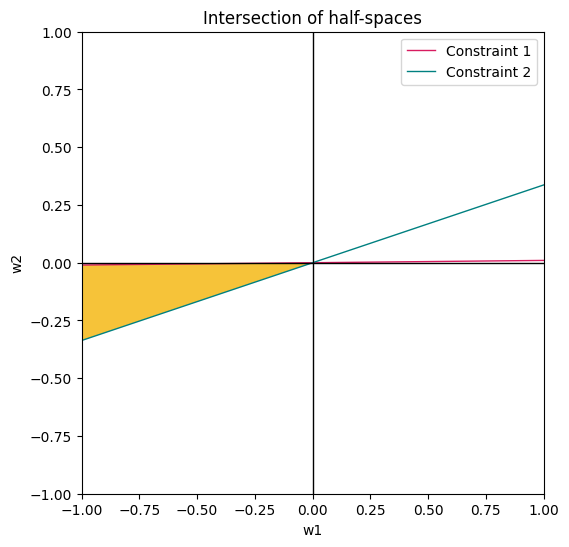

In [37]:
plot_halfspace_intersection_2d(U_global)

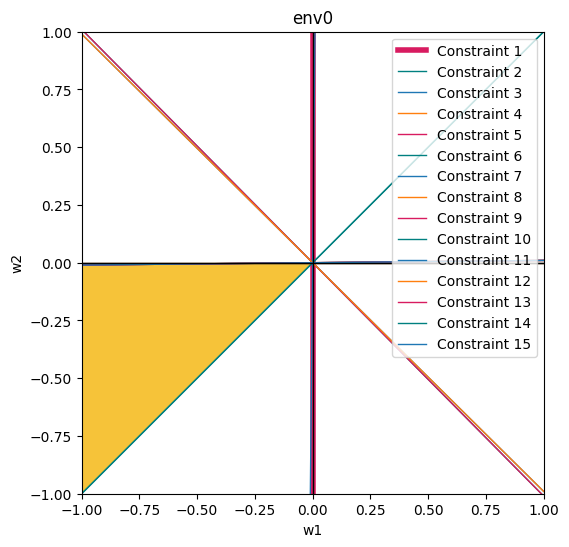

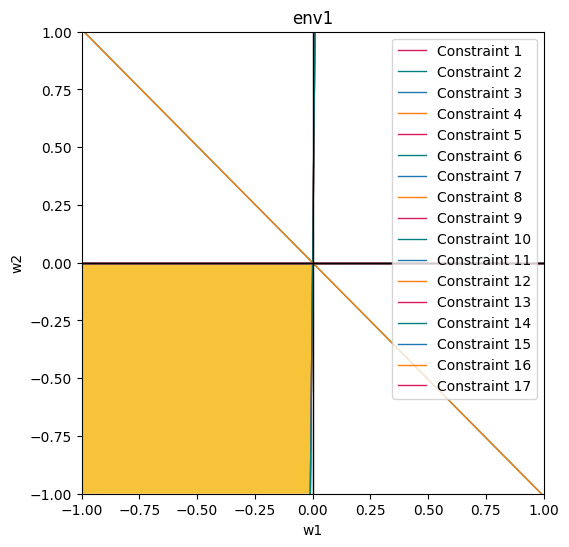

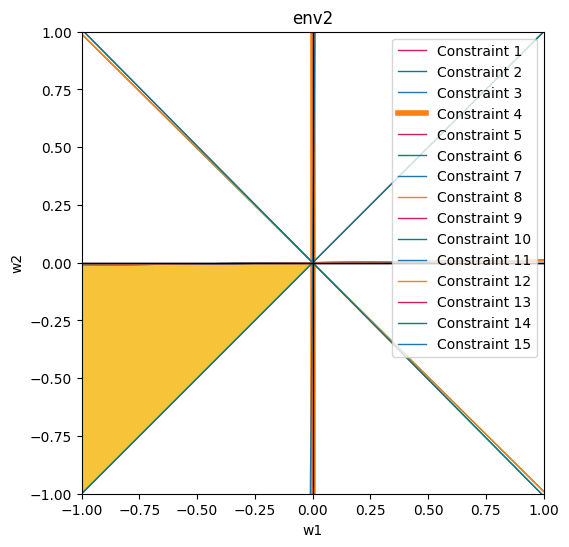

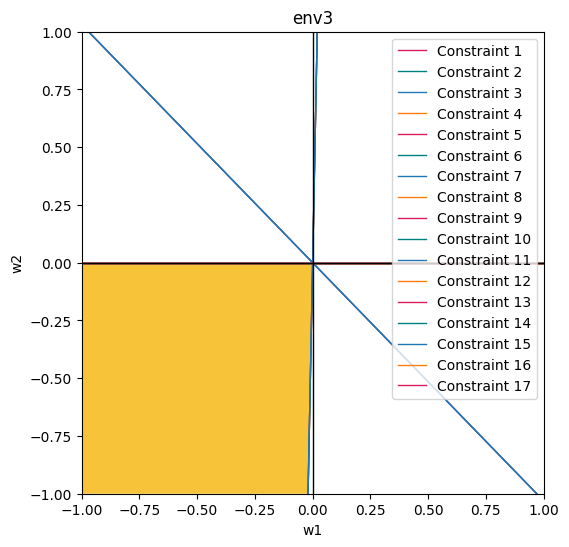

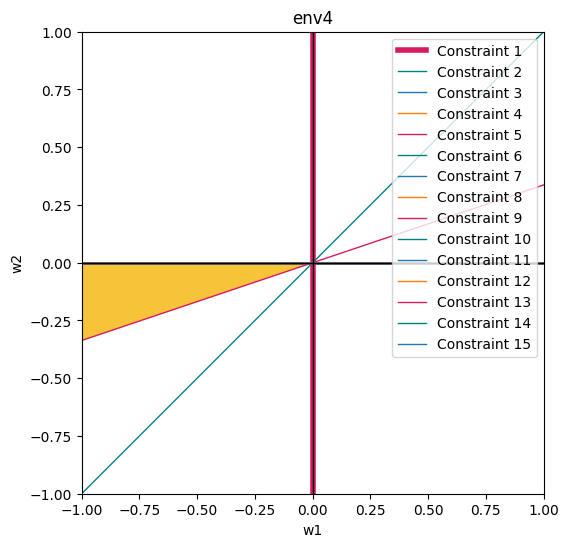

In [38]:
for i, u in enumerate(U_per_mdp):

    plot_halfspace_intersection_2d(u, title=f"env{i}")

In [39]:

# --- 3) Candidate demos per MDP (greedy policy rollouts from Q) ---
candidates = generate_candidates_from_q_family(
    envs,
    envs_Q,
    num_rollouts_per_state=5,   # adjust as you like
    max_steps=12,
    tie_eps=1e-10,
)

# --- 4) Unweighted greedy cover over family constraints ---
chosen = scot_greedy_family_unweighted(
    U_global=U_global,
    candidates=candidates,
    SFs=SFs,
    normalize=True,
    round_decimals=12,
)
# chosen is: List[(mdp_index, trajectory_list_of_(s,a))]
# Example: [(0, [(s0,a2), (s5,a1), ...]), (1, [...]), ...]

starting state:  1
optimal actions:  [2]
starting state:  1
optimal actions:  [2]
starting state:  1
optimal actions:  [2]
starting state:  1
optimal actions:  [2]
starting state:  1
optimal actions:  [2]
starting state:  2
optimal actions:  [2]
optimal actions:  [2]
starting state:  2
optimal actions:  [2]
optimal actions:  [2]
starting state:  2
optimal actions:  [2]
optimal actions:  [2]
starting state:  2
optimal actions:  [2]
optimal actions:  [2]
starting state:  2
optimal actions:  [2]
optimal actions:  [2]
starting state:  3
optimal actions:  [0]
starting state:  3
optimal actions:  [0]
starting state:  3
optimal actions:  [0]
starting state:  3
optimal actions:  [0]
starting state:  3
optimal actions:  [0]
starting state:  4
optimal actions:  [2]
optimal actions:  [0]
starting state:  4
optimal actions:  [2]
optimal actions:  [0]
starting state:  4
optimal actions:  [2]
optimal actions:  [0]
starting state:  4
optimal actions:  [2]
optimal actions:  [0]
starting state:  4
opti

In [40]:
chosen

[(0, [(2, 2), (1, 2)]), (4, [(2, 1), (5, 2), (4, 2), (3, 0)])]

In [41]:
from collections import defaultdict

def merge_chosen(chosen):
    merged = defaultdict(list)
    for env_idx, traj in chosen:
        if traj:  # skip empty ones
            merged[env_idx].extend(traj)
    # convert to sorted list of tuples
    return [(i, merged[i]) for i in sorted(merged.keys())]


demos_by_env = merge_chosen(chosen)

In [42]:
demos_by_env

[(0, [(2, 2), (1, 2)]), (4, [(2, 1), (5, 2), (4, 2), (3, 0)])]

In [43]:


# Convert demos -> per-env list
demos = [[] for _ in range(len(envs))]
for env_idx, pairs in demos_by_env:
    demos[env_idx].extend(pairs)

In [44]:
demos

[[(2, 2), (1, 2)], [], [], [], [(2, 1), (5, 2), (4, 2), (3, 0)]]

### running BIRL on multiple mdps

In [28]:
birlf = MultiEnvBIRL(envs=envs, demos=demos_by_env, beta=10, epsilon=1e-4)
birlf.run_mcmc(samples=2000, stepsize=0.1, normalize=True, adaptive=True)
w_map  = birlf.get_map_solution()
w_mean = birlf.get_mean_solution(burn_frac=0.2, skip_rate=10)

In [29]:
w_map

array([-0.96169633, -0.27411706])

### Solving MDPS using learned reward function

In [30]:
# ---- main: solve & print policies for all envs using MAP weights ----
def print_policies_with_map(birl, shapes=None, tie_eps=1e-8):
    """
    birl: MultiEnvBIRL instance already run (has map_sol)
    shapes: optional list/dict mapping env index -> (rows, cols)
            e.g., shapes={0:(5,7), 1:(4,4)} or list like [(5,7),(4,4),...]
    """
    w_map = birl.get_map_solution()
    assert w_map is not None, "MAP solution is None. Run birl.run_mcmc(...) first."

    for i, env in enumerate(birl.envs):
        # Set weights and solve VI fresh
        env.set_feature_weights(w_map)
        vi = ValueIteration(env)
        vi.run_value_iteration(epsilon=getattr(birl, "epsilon", 1e-4))
        Q = vi.get_q_values()

        # terminals if available
        ts = getattr(env, "terminal_states", []) or []


        rows, cols = (shapes[i] if isinstance(shapes, (list, tuple)) else shapes[i])

        #print(f"=== Env {i} | rows={rows}, cols={cols} ===")
        print_policy_from_q(Q, rows, cols, tie_eps=tie_eps, terminal_states=ts)

In [31]:
print_policies_with_map(birlf, shapes=[(env.rows, env.columns) for env in envs], tie_eps=1e-8)

T | < | <
^ | < | ^

>  | T  | < 
^> | ^  | ^<

> | > | T
^ | > | ^

v  | v< | v<
T  | <  | < 

T | < | v
^ | < | <

